In [1]:
"""
    Returns a cleaned X and y dataset to be used for classification.
"""
import os
import cv2
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import misc
from matplotlib.image import imread
import matplotlib.pyplot as plt





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH=r"C:\Users\Jeroen Gijsbers\OneDrive - TU Eindhoven\Uni\Master\Jaar 1\Kwartiel 3\2AMV10 - Visual Analytics\Project\2AMV10-group-16"
PATH_m = r"/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16"
IMG_SIZE = 180

In [4]:
def read_data():
    """
        Reads the images and returns them as arrays X and y

        returns: X      array containing np-array-representation of images
                 y      array containing corresponding labels
    """
    #print(os.curdir)
    #os.chdir('../data/trainingData/TrainingImages')
    X = []
    y = []
    labels = []
    sys.path.insert(0, PATH_m)

    path = "/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/data/trainingData/TrainingImages"
    i = 0
    limit = 200
    for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
        labels.append(label)
        for image in [name for name in os.listdir(f"{path}/{label}")]:
            #X.append(cv2.imread(f"{path}/{label}/{image}"))
            try:
                X.append(cv2.imread(f"{path}/{label}/{image}"))
                y.append(label)
                i+= 1
            except:
                print("something went wrong, probably .db file")
            if i == limit:
                break
        if i == limit:
            break
    return np.array(X), y, labels#.reshape(50, 256*256), y, labels

In [5]:
import joblib
from sklearn.model_selection import train_test_split, cross_validate

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


from random import randint
import cv2
import pandas as pd


In [6]:
X, y, labels = read_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
print(len(X))

200


In [8]:
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def process_img(sample):
  try:
    # print(sample.shape)
    sample = tf.cast(sample, tf.float32)
    sample = sample / 255.
    sample = tf.image.resize(sample, [IMG_SIZE, IMG_SIZE])
    return sample
  except ValueError or AttributeError:
    print(sample)

X = [process_img(x) for x in X]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [9]:
from sklearn.model_selection import train_test_split
class Classifier:
    def __init__(self):
        batch_size = 32
        img_height = 180
        img_width = 180

    def predict(self, image):
        """
            Takes an image, converts it to a np array, and uses the model to predict a label.

            Returns:
                pred    String      predicted label
        """
        if not self.rf:
            print("Please fit the model first.")
            return
        test = cv2.imread(image, mode="RGB")
        return self.rf.predict(test)

    def load_data(self):
        """
            Splits the data into a train and a test set.
        """
        self.X, self.y, self.labels = read_data()
        #enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
        #self.X = enc.fit_transform(self.X, self.y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25)
        print(f"Shape of training image: {self.X_train[0].shape}")

    def show_images(self, grayscale=False, display_test=False):
        """
            Shows 10 random images from the dataset
        """
        def plot_images(X, y, grayscale=False, display_test=False):
            fig, axes = plt.subplots(1, len(X), figsize=(15,30))
            for n in range(len(X)):
                if grayscale:
                    axes[n].imshow(X[n], cmap='gray')
                else:
                    axes[n].imshow(X[n])
                print(y[n])
                print(np.argmax(y[n]))
                print(self.labels[:5])
                print(self.labels[np.argmin(y[n])])
                axes[n].set_xlabel(self.labels[np.argmin(y[n])])
                axes[n].set_xticks(()), axes[n].set_yticks(())
            plt.show()

        images = [randint(0,len(self.X_train)-1) for i in range(5)]
        X_random = [self.X_train[i] for i in images]
        y_random = [self.y_train[i] for i in images]
        plot_images(X_random, y_random)

        if display_test:
            images = [randint(0,len(self.X_test)) for i in range(5)]
            X_random = [self.X_test[i] for i in images]
            y_random = [self.y_test[i] for i in images]
            plot_images(X_random, y_random)


    def build(self):
        """
            Fits the model
        """
        model = models.Sequential()
        model.add(layers.Conv2D(512, (3, 3), activation='relu',
                                input_shape=IMG_SHAPE))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(256, (3, 3), activation='relu',
                                input_shape=IMG_SHAPE))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))
        model.add(layers.Flatten())
        #model.add(layers.Dense(512, activation='relu'))
        model.add(layers.Dense(len(self.labels), activation='sigmoid'))
        rmsprop_optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

        model.compile(
            optimizer=rmsprop_optimizer,
            loss="categorical_crossentropy",
            metrics=['accuracy']
        )
        self.model = model

    def evaluate(self, train=None, stop_training=False, generator=None):
        learning_curves = {}
        if train and not stop_training:
            if generator:
                # TODO: deploy generator
                pass
            else:
                history = self.model.fit(
                    self.X_train, self.y_train, epochs=3, batch_size=3,
                    verbose=1, validation_data=(self.X_val, self.y_val))
                learning_curves = history.history
            # TODO: save to file
        else:
            # TODO: load from file
            pass
        lc = pd.DataFrame(learning_curves)
        print(f"Max val score: {lc.iloc[:,3].max()*100}%")
        lc.plot(lw=2, style=['b:', 'r:', 'b-', 'r-'])
        plt.xlabel('epochs')
        plt.show()

        print(self.model.summary())
        plot_model(self.model)

                

    def test(self):
        """
            Get accuracy scores based X_test and y_test
            TODO implement
        """
        if not self.X_test:
            self.train()
        xvals = cross_validate(self.rf, self.X, self.y, return_train_score=True, n_jobs=-1)
        return xvals['train_score'], xvals['test_score']


    def feature_importance(self, nr_images=10, nr_rows=2):
        """
            Plot graphs with images and importances
            for nr_images images on nr_rows rows

            TODO implement
        """
        fig, ax = plt.subplots(nr_images, nr_rows)
        pass


    def misclassifications(self):
        """
            Plot items with their misinterpreted label
        """
        y_pred = self.rf.predict(self.X_test)
        misclassified = np.nonzero(y_pred != list(self.y_test))[0]

    def save(self):
        if not self.rf:
            print("Unable to save model since it doesn't exist")
        joblib.dump(self.rf, "./random_forest.joblib", compress=3)

    def load(self):
        self.rf = joblib.load("./random_forest.joblib")


1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Shape of training image: (3456, 5184, 3)
pumpkinNotes
0
['legoBracelet', 'metalKey', 'paperPlate', 'spiderRing', 'vancouverCards']
legoBracelet
vancouverCards
0
['legoBracelet', 'metalKey', 'paperPlate', 'spiderRing', 'vancouverCards']
legoBracelet
rainbowPens
0
['legoBracelet', 'metalKey', 'paperPlate', 'spiderRing', 'vancouverCards']
legoBracelet
spiderRing
0
['legoBracelet', 'metalKey', 'paperPlate', 'spiderRing', 'vancouverCards']
legoBracelet
redBow
0
['legoBracelet', 'metalKey', 'paperPlate', 'spiderRing', 'vancouverCards']
legoBracelet


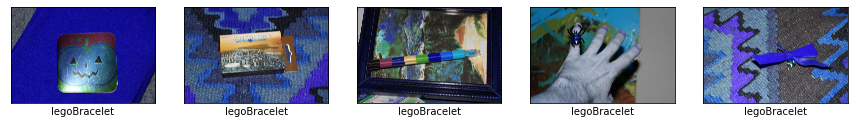

In [10]:
model = Classifier()
print(1)
model.load_data()

model.show_images()

In [11]:
print(0)
model = Classifier()
print(1)
model.load_data()
print(1)
model.build()

0
1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Shape of training image: (1482, 2924, 3)
1


NameError: ignored